<a href="https://colab.research.google.com/github/devikamsba2024/Deep_Learning/blob/main/IMDB_MovieReviews_SentimentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3**

**Classifying the IMDB reviews' sentiment into positive(1) or negative(0)**

In [ ]:
!pip install -q --upgrade "transformers>=4.39.0" datasets scikit-learn accelerate --no-cache-dir
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import csv
import re

import os, random, torch, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report ,precision_recall_fscore_support
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,DataCollatorWithPadding,
                           get_scheduler, get_linear_schedule_with_warmup)
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.utils.data import random_split
from pathlib import Path




## **Load's the Data**

In [ ]:
# Load the dataset
train_df = pd.read_csv('/content/Train 2.csv', encoding='utf-8')
test_df = pd.read_csv('/content/Test.csv', encoding='utf-8')

# Show the shape of the dataset
print("Train Dataset Shape:", train_df.shape)
print("Test Dataset Shape:", test_df.shape)

# Display first few rows
train_df.head()




Train Dataset Shape: (40000, 2)
Test Dataset Shape: (5000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## **Class Distribution of Dataset**

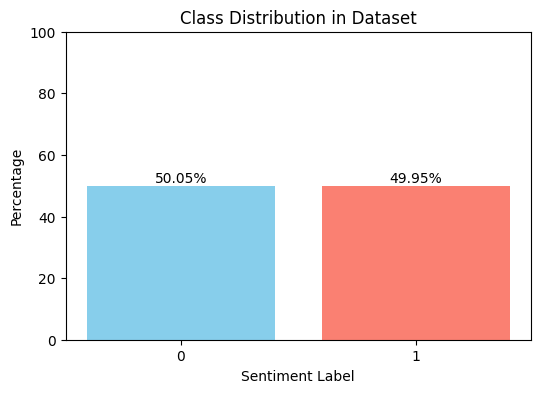

In [ ]:
label_distribution = train_df['label'].value_counts(normalize=True).rename_axis('Label').reset_index(name='Proportion')
label_distribution['Percentage'] = label_distribution['Proportion'] * 100

plt.figure(figsize=(6, 4))
plt.bar(label_distribution['Label'].astype(str), label_distribution['Percentage'], color=['skyblue', 'salmon'])
plt.xlabel('Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage')
plt.title('Class Distribution in Dataset')
plt.ylim(0, 100)
for i, val in enumerate(label_distribution['Percentage']):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=10)
plt.show()

## **Text Length(character and word) Distrubutions**

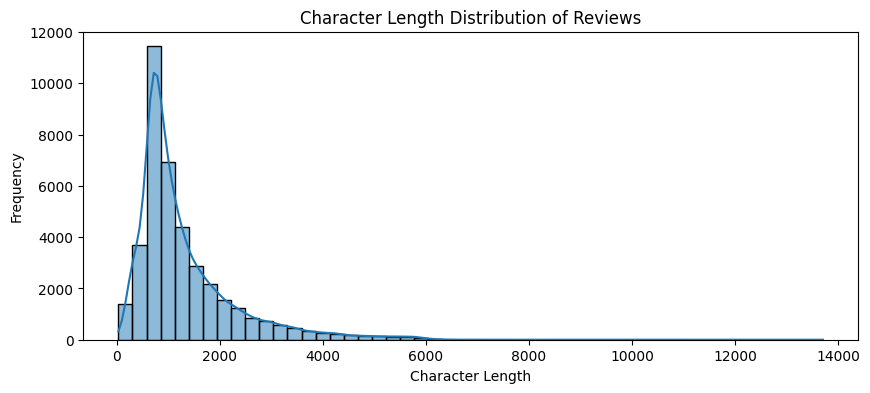

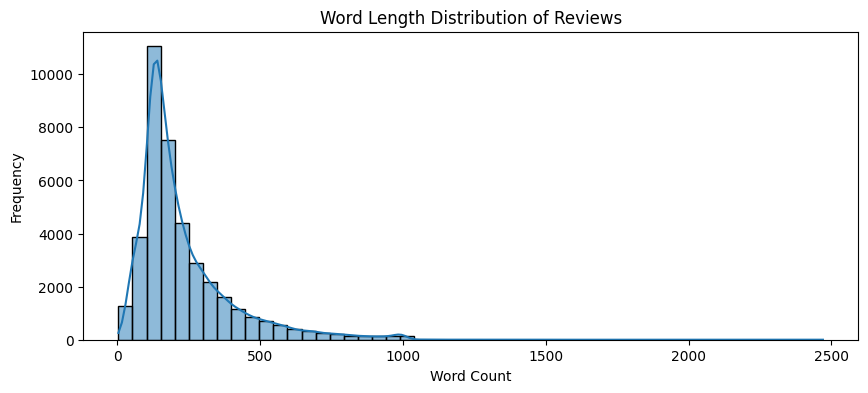

In [ ]:
# Calculate lengths
train_df['char_length'] = train_df['text'].apply(len)
train_df['word_length'] = train_df['text'].apply(lambda x: len(x.split()))
# Plot character length distribution
plt.figure(figsize=(10, 4))
sns.histplot(train_df['char_length'], bins=50, kde=True)
plt.title("Character Length Distribution of Reviews")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

# Plot word length distribution
plt.figure(figsize=(10, 4))
sns.histplot(train_df['word_length'], bins=50, kde=True)
plt.title("Word Length Distribution of Reviews")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

## **Clean the Text(HTML tags, white spaces...)**

In [ ]:
def clean_text(text):
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip().lower()

# Apply to the 'text' column
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = train_df['text'].apply(clean_text)

## **Word Cloud to see most frequent words**

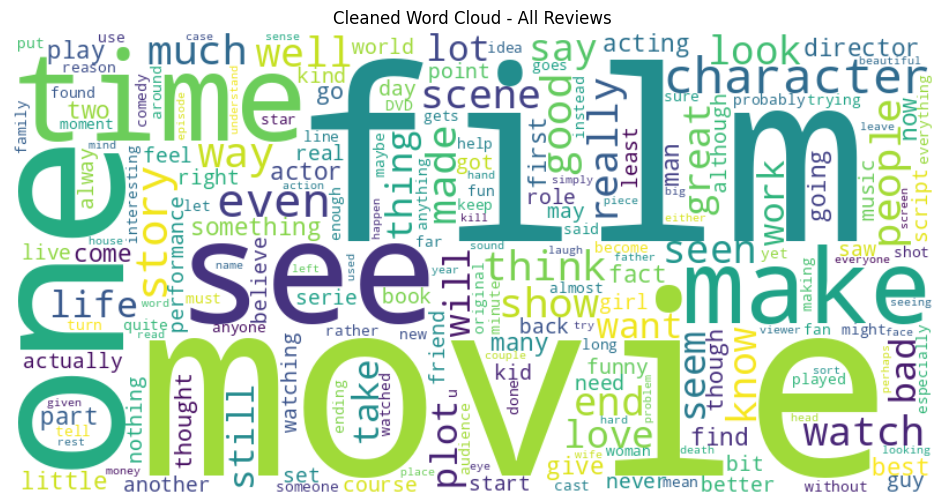

In [ ]:
# WordCloud for all reviews
all_text = ' '.join(train_df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(all_text)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Cleaned Word Cloud - All Reviews')
plt.show()



## **WordCloud for positive reviews**

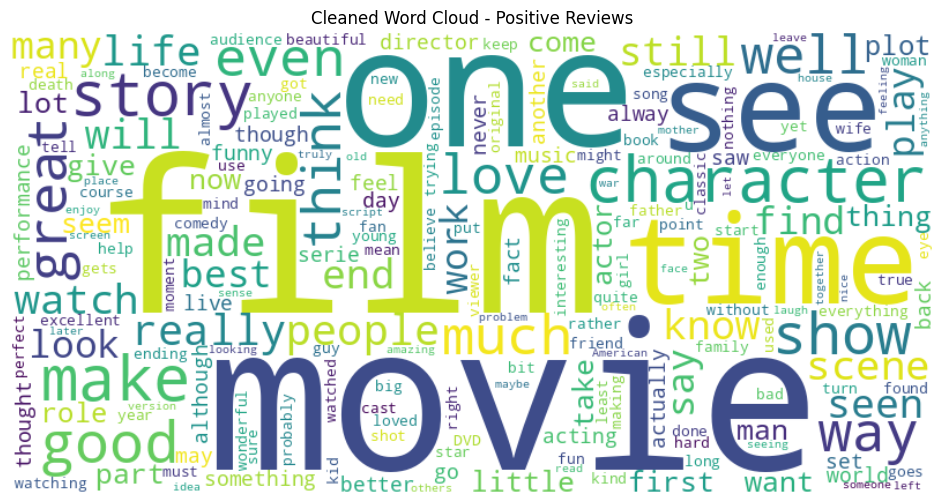

In [ ]:
# WordCloud for positive reviews
positive_text = ' '.join(train_df[train_df['label'] == 1]['clean_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(positive_text)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Cleaned Word Cloud - Positive Reviews')
plt.show()



## **WordCloud for negative reviews**

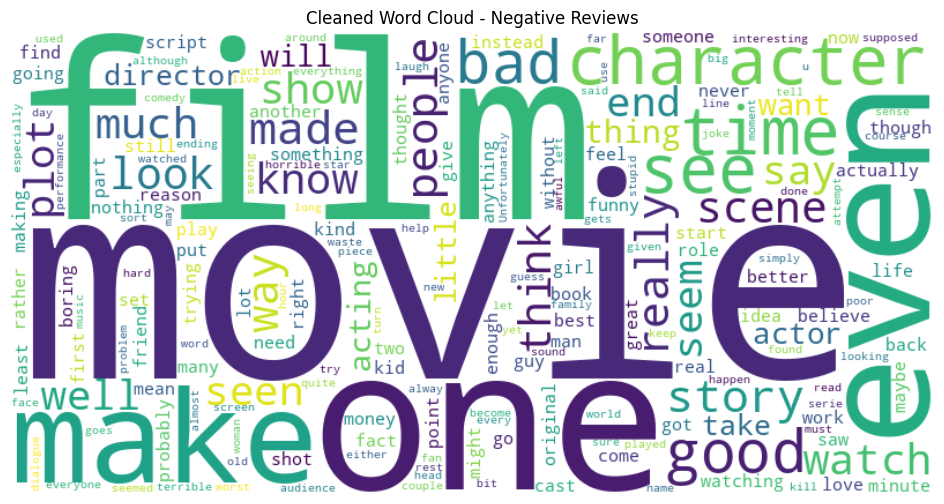

In [ ]:
# WordCloud for negative reviews
negative_text = ' '.join(train_df[train_df['label'] == 0]['clean_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(negative_text)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Cleaned Word Cloud - Negative Reviews')
plt.show()

# **BERT**

## **Change's to GPU**

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Splitting Train set to Train and Validation set**

In [ ]:
# train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_df["text"].tolist(),
    train_df["label"].tolist(),
    test_size=0.2,
    stratify=train_df["label"],
    random_state=SEED,
)

## **Tokenizing the Text**

In [ ]:
# =========================================
# 2. Tokenize
# =========================================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )

train_enc  = tokenize(X_train)
val_enc    = tokenize(X_val)
test_enc   = tokenize(test_df["text"].tolist())

## **Wrapping the dataset into Pythorch data frames**

In [ ]:
# =========================================
# 3. Dataset / Dataloader
# =========================================
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_ds = SentimentDataset(train_enc, y_train)
val_ds   = SentimentDataset(val_enc,   y_val)
test_ds  = SentimentDataset(test_enc,  test_df["label"].tolist())

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=16)

## **Loading the BERT**

In [ ]:

# =========================================
# 4. Model, Optimizer, Scheduler
# =========================================
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Training the model with early Stopping of low validation loss which avoids overfitting**

In [ ]:
# =========================================
# 5. Training loop with early stopping
# =========================================
best_val_loss = float("inf")
patience      = 2
no_improve    = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # ---- train ----
    model.train()
    total_loss, total_correct, total_examples = 0, 0, 0
    for batch in tqdm(train_loader, desc="Train"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == batch["labels"]).sum().item()
        total_examples += batch["labels"].size(0)

    train_loss = total_loss / len(train_loader)
    train_acc  = total_correct / total_examples
    print(f"  Train loss {train_loss:.4f} | acc {train_acc:.4f}")

    # ---- validate ----
    model.eval()
    val_loss, val_correct, val_examples = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Val  "):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss, logits = outputs.loss, outputs.logits

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == batch["labels"]).sum().item()
            val_examples += batch["labels"].size(0)

    val_loss /= len(val_loader)
    val_acc   = val_correct / val_examples
    print(f"  Val   loss {val_loss:.4f} | acc {val_acc:.4f}")

    # ---- early stopping & save best ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        model.save_pretrained("./best_bert_model")
        tokenizer.save_pretrained("./best_bert_model")
        print("Saved best model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered")
            break


Epoch 1/3


Train:   0%|          | 0/2000 [00:00<?, ?it/s]

  Train loss 0.2420 | acc 0.9085


Val  :   0%|          | 0/500 [00:00<?, ?it/s]

  Val   loss 0.2082 | acc 0.9227
  ✔ Saved best model

Epoch 2/3


Train:   0%|          | 0/2000 [00:00<?, ?it/s]

  Train loss 0.1300 | acc 0.9626


Val  :   0%|          | 0/500 [00:00<?, ?it/s]

  Val   loss 0.2319 | acc 0.9383

Epoch 3/3


Train:   0%|          | 0/2000 [00:00<?, ?it/s]

  Train loss 0.0679 | acc 0.9836


Val  :   0%|          | 0/500 [00:00<?, ?it/s]

  Val   loss 0.2757 | acc 0.9403
  ✋ Early stopping triggered


## **Loads the saved model and performs evaluation**

In [ ]:
# =========================================
# 6. Load best model & test evaluation
# =========================================
print("\nLoading best model for test evaluation...")
best_model = AutoModelForSequenceClassification.from_pretrained(
    "./best_bert_model"
).to(device)
best_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test "):
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = best_model(**batch).logits
        preds  = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch["labels"].cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)



Loading best model for test evaluation...


Test :   0%|          | 0/313 [00:00<?, ?it/s]

## **Evaluation Results**

In [ ]:

print(f"\nTest Accuracy: {test_acc:.4f}")

print(classification_report(all_labels, all_preds, digits=4))


Test Accuracy: 0.9330
              precision    recall  f1-score   support

           0     0.9069    0.9647    0.9349      2495
           1     0.9625    0.9014    0.9309      2505

    accuracy                         0.9330      5000
   macro avg     0.9347    0.9331    0.9329      5000
weighted avg     0.9348    0.9330    0.9329      5000



# **DeBERTa**

## **Load's Tokenizer**

In [ ]:
# 2. DeBERTa‑v3 base tokenizer ----------------------------------------------
ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(ckpt)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## **Wrapping into pytorch Dataset**

In [ ]:
# 3. PyTorch Dataset ---------------------------------------------------------
class ReviewDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.labels = df["label"].tolist()
        self.encs = tokenizer(df["text"].tolist(),
                              truncation=True,
                              padding=False,
                              max_length=512)
    def __len__(self):  return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encs.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

full_train_ds = ReviewDataset(train_df, tokenizer)
test_ds       = ReviewDataset(test_df,  tokenizer)

## **Splitting Train data into Train and Validation Sets**

In [ ]:

# 4. 80 / 20 split  ------------------------------------------
train_len = int(0.8 * len(full_train_ds))
val_len   = len(full_train_ds) - train_len
train_ds, val_ds = random_split(full_train_ds,
                                [train_len, val_len],
                                generator=torch.Generator().manual_seed(SEED))

collator = DataCollatorWithPadding(tokenizer)
BATCH = 16
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  collate_fn=collator)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, collate_fn=collator)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, collate_fn=collator)


## **Load's the model**

In [ ]:
# 5. DeBERTa model, optimiser, scheduler -------------------------------------
model = AutoModelForSequenceClassification.from_pretrained(ckpt, num_labels=2).to(device)

epochs = 3
optim  = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # <- slightly lower LR
total_steps = epochs * len(train_loader)
scheduler   = get_linear_schedule_with_warmup(
                 optim,
                 num_warmup_steps=int(0.1 * total_steps),
                 num_training_steps=total_steps)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Trains the model with early‑stopping on val‑loss**

In [ ]:
# 6. Train with early‑stopping on val‑loss -----------------------------------
save_dir = Path("best_deberta")
best_val, patience, waited = float('inf'), 2, 0

for ep in range(1, epochs+1):
    # ---- training ----
    model.train()
    tr_loss, tr_correct = 0.0, 0
    for batch in tqdm(train_loader, desc=f"Train {ep}"):
        batch = {k:v.to(device) for k,v in batch.items()}
        out   = model(**batch)
        loss, logits = out.loss, out.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step(); scheduler.step(); optim.zero_grad()

        tr_loss   += loss.item() * batch["labels"].size(0)
        tr_correct += (logits.argmax(1)==batch["labels"]).sum().item()

    # ---- validation ----
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val   {ep}"):
            batch = {k:v.to(device) for k,v in batch.items()}
            out   = model(**batch)
            loss, logits = out.loss, out.logits
            val_loss   += loss.item() * batch["labels"].size(0)
            val_correct += (logits.argmax(1)==batch["labels"]).sum().item()

    avg_tr  = tr_loss  / len(train_ds)
    avg_val = val_loss / len(val_ds)
    tr_acc  = tr_correct  / len(train_ds)
    val_acc = val_correct / len(val_ds)
    print(f"Epoch {ep}: train {avg_tr:.4f}/{tr_acc:.3f} | "
          f"val {avg_val:.4f}/{val_acc:.3f}")

    if avg_val < best_val:
        best_val, waited = avg_val, 0
        save_dir.mkdir(exist_ok=True)
        model.save_pretrained(save_dir); tokenizer.save_pretrained(save_dir)
        print(f"   New best saved to {save_dir}")
    else:
        waited += 1
        if waited >= patience:
            print("  Early‑stopping: no improvement.")
            break

Train 1:   0%|          | 0/2000 [00:00<?, ?it/s]

Val   1:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: train 0.2251/0.907 | val 0.1274/0.957
  ✔️  New best saved to best_deberta


Train 2:   0%|          | 0/2000 [00:00<?, ?it/s]

Val   2:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2: train 0.1130/0.969 | val 0.1288/0.964


Train 3:   0%|          | 0/2000 [00:00<?, ?it/s]

Val   3:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3: train 0.0751/0.982 | val 0.1628/0.963
  Early‑stopping: no improvement.


## **Reload the Best Model**

In [ ]:
# 7. Reload best checkpoint ---------------------------------------------------
best_model = AutoModelForSequenceClassification.from_pretrained(save_dir).to(device)
best_model.eval()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## **Evaluation on Test set**

In [ ]:
# 8. Test‑set evaluation ------------------------------------------------------

preds, labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        lbl = batch['labels']
        batch = {k:v.to(device) for k,v in batch.items()}
        logits = best_model(**batch).logits.detach().cpu()
        preds.extend(logits.argmax(1).tolist())
        labels.extend(lbl.tolist())

acc = accuracy_score(labels, preds)
prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print("\n=== DeBERTa Test Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1‑score : {f1:.4f}")
print("\nDetailed report:")
print(classification_report(labels, preds, digits=4))

Test:   0%|          | 0/313 [00:00<?, ?it/s]


=== DeBERTa Test Results ===
Accuracy : 0.9540
Precision: 0.9414
Recall   : 0.9685
F1‑score : 0.9547

Detailed report:
              precision    recall  f1-score   support

           0     0.9674    0.9395    0.9532      2495
           1     0.9414    0.9685    0.9547      2505

    accuracy                         0.9540      5000
   macro avg     0.9544    0.9540    0.9540      5000
weighted avg     0.9544    0.9540    0.9540      5000



## **DeBERTa vs BERT**

1.   BERT Test Accuracy : 93%
2.   DeBERTa Test Accuracy : 95%

With slight difference DeBERTa performed well


